In [1]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
import create_billards_data as bd
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchdiffeq import odeint
%matplotlib inline

In [2]:
train=False

In [3]:
def simulate_bb(timesteps=1000, balls=5, masses=None, radiuses=None, mass_wall=-1):
    if masses is None:
        masses = np.ones((balls, 1))
    if radiuses is None:
        radiuses = np.ones((balls, 1))*0.5

    # Define constant shape = 0 = circle
    shapes = np.zeros((balls, 1))

    x,y = bd.bounce_n(T=timesteps,n=balls,m=masses, r=radiuses)
    simulation = np.concatenate((x, y), axis=2)
    
    masses = np.tile([masses], (timesteps, 1, 1))
    radiuses = np.tile([radiuses], (timesteps, 1, 1))
    shapes = np.tile([shapes], (timesteps, 1, 1))
    
    temp_data = np.concatenate((masses, simulation), axis=2)
    temp_data = np.concatenate((radiuses, temp_data), axis=2)
    temp_data = np.concatenate((shapes, temp_data), axis=2)
    data = np.zeros((timesteps, balls+4, 7))
    for i in range(timesteps):
        walls = [[1, bd.SIZE, mass_wall, -bd.SIZE/2.0         , bd.SIZE/2.0          , 0, 0], 
                 [1, bd.SIZE, mass_wall, bd.SIZE/2.0          , -bd.SIZE/2.0         , 0, 0], 
                 [1, bd.SIZE, mass_wall, bd.SIZE + bd.SIZE/2.0, bd.SIZE/2.0          , 0, 0], 
                 [1, bd.SIZE, mass_wall, bd.SIZE/2.0          , bd.SIZE + bd.SIZE/2.0, 0, 0]]
        data[i] = np.concatenate((temp_data[i], walls), axis=0)
    return data

In [4]:
sizes=np.random.rand(5).reshape(5,1) + 0.2
testsim = simulate_bb(timesteps=100, balls=5, masses=sizes, radiuses=sizes)

In [5]:
#testsim[0]

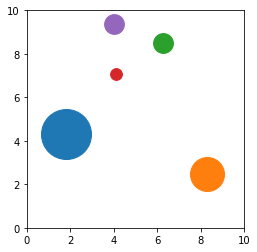

In [6]:
plt.ion()
for i in range(0,10):
    clear_output(True)
    plt.ylim(0,10)
    plt.xlim(0,10)
    plt.gca().set_aspect('equal', adjustable='box')
    for j in range(0,5):
        plt.scatter(x=testsim[i][j][3],y=testsim[i][j][4],s=sizes[j]**2*1900)
    plt.show()
plt.ioff()

In [7]:
class InteractionDataset(Dataset):
    """Interaction Networks bouncing balls dataset"""
    def __init__(self, n_timesteps, n_simulations, n_balls, n_relations, relation_dim):
        self.n_walls                 = 4
        self.n_features              = 7
        self.n_objects               = n_balls + n_walls
        self.n_relations             = n_relations
        self.relation_dim            = relation_dim
        self.train                   = train
        
        self.n_timesteps        = n_timesteps
        self.n_simulations      = n_simulations
        # Generate masses and sizes for balls between interval [0.2, 1.2)
        self.masses             = np.random.rand(n_simulations*n_balls).reshape(n_simulations,n_balls,1) + 0.2
        self.radiuses           = np.random.rand(n_simulations*n_balls).reshape(n_simulations,n_balls,1) + 0.2
        
        self.simulations        = np.zeros((n_simulations, n_timesteps, n_objects, n_features))
        self.initial_state      = np.zeros((n_simulations, n_objects, n_features))
        
        for s in range(n_simulations):
            self.simulations[s] = simulate_bb(timesteps=n_timesteps, balls=n_balls, masses=self.masses[s], radiuses=self.radiuses[s])
            self.initial_state[s] = self.simulations[s, 0, :, :]

        self.simulations        = Variable(torch.FloatTensor(self.simulations))
        self.initial_state      = Variable(torch.FloatTensor(self.initial_state))
        self.times              = Variable(torch.arange(0,self.n_timesteps, out=torch.LongTensor()))
        
    def __len__(self):
        return self.n_simulations
    
    def __getitem__(self, idx):
        times = self.times

        return self.initial_state[idx].reshape(self.n_objects, self.n_features), self.simulations[idx, times, :, :].reshape(self.n_timesteps, self.n_objects, self.n_features), times.float()

In [8]:
# Test InteractionDataset
n_balls = 3
n_walls = 4
n_objects = n_balls + n_walls
n_relations = n_objects*(n_objects-1)
n_timesteps = 10
n_simulations = 1
relation_dim = 1
n_features=7
test_samples = InteractionDataset(n_timesteps, n_simulations, n_balls, n_relations, relation_dim)

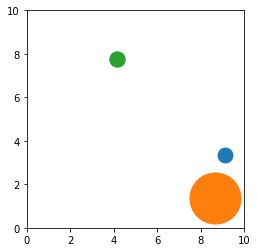

In [9]:
plt.ion()
state, all_states, times = test_samples[0]
for i in range(0,n_timesteps):
    clear_output(True)
    plt.ylim(0,10)
    plt.xlim(0,10)
    plt.gca().set_aspect('equal', adjustable='box')
    for b in range(0,n_balls):
        plt.scatter(x=all_states[i][b][3],y=all_states[i][b][4],s=test_samples.radiuses[0][b]**2*2000)
    plt.show()
plt.ioff()

In [10]:
device = torch.device('cuda:0')
#device = torch.device('cpu')

In [11]:
# Training settings
n_balls = 3
n_walls = 4
n_objects = n_balls + n_walls
n_relations = n_objects*(n_objects-1)
n_timesteps_train = 8 # initial state + future states
n_simulations = 1024*128
n_features = 7
relation_dim = 1
effect_dim = 100
batch_size_train = 2048

if train:
    trainset = InteractionDataset(n_timesteps_train, n_simulations, n_balls, n_relations, relation_dim)
    trainloader = DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=8)

In [12]:
class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc

    def forward(self, t, x):
        out = odeint(self.odefunc, x, t, method='euler')
        return out

In [13]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        #batch_size, n_relations, input_size = x.size()
        #x = x.view(-1, input_size)
        x = self.layers(x)
        #x = x.view(batch_size, n_relations, self.output_size)
        return x

In [14]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size), #predicted state
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size, n_objects, output_size]
        '''
        #input_size = x.size(2)
        #x = x.view(-1, input_size)
        return self.layers(x)

In [15]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, n_balls, object_dim, n_relations, relation_dim, effect_dim, batch_size):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model   = RelationalModel(2*object_dim + relation_dim, effect_dim, 150).to(device)
        self.object_model       = ObjectModel(object_dim + effect_dim, 100, 4).to(device)
        
        self.receiver_relations = Variable(torch.FloatTensor([])).to(device)
        self.sender_relations   = Variable(torch.FloatTensor([])).to(device)
        self.relation_info      = Variable(torch.FloatTensor([])).to(device)
        
        self.set_relations(n_objects, n_balls, batch_size, device)
    
    def set_relations(self, n_objects, n_balls, batch_size, device):
        receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float)
        sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float)
        relation_info      = np.ones((batch_size, n_relations, relation_dim), dtype=float)
        
        # Generate onehot matrices for relations
        for s in range(batch_size):
            cnt = 0
            for i in range(n_objects):
                for j in range(n_objects):
                    if(i != j):
                        # Do not add relation from ball to wall or from wall to wall
                        if not ((j < n_balls and i >= n_balls) or (i >= n_balls and j >= n_balls)):
                            receiver_relations[s, i, cnt] = 1.0
                            sender_relations[s, j, cnt] = 1.0
                        cnt += 1
    
        self.receiver_relations = Variable(torch.FloatTensor(receiver_relations)).to(device)
        self.sender_relations   = Variable(torch.FloatTensor(sender_relations)).to(device)
        self.relation_info      = Variable(torch.FloatTensor(relation_info)).to(device)
    
    def forward(self, t, x):
        constants   = x[:,:,0:3]
        batch_size  = x.shape[0]
        senders     = self.sender_relations[0:batch_size,:,:].permute(0, 2, 1).bmm(x)
        receivers   = self.receiver_relations[0:batch_size,:,:].permute(0, 2, 1).bmm(x)
        
        m = torch.cat([senders, receivers, self.relation_info[0:batch_size,:,:]], 2)
        effects = self.relational_model(m)
        effect_receivers = self.receiver_relations[0:batch_size,:,:].bmm(effects)
        a = torch.cat([x, effect_receivers], 2)

        out = self.object_model(a)
        return torch.cat([constants, out], 2)

In [16]:
ode_network = ODEBlock(InteractionNetwork(n_objects, n_balls, n_features, n_relations, relation_dim, effect_dim, batch_size_train))
ode_network.to(device)

ODEBlock(
  (odefunc): InteractionNetwork(
    (relational_model): RelationalModel(
      (layers): Sequential(
        (0): Linear(in_features=15, out_features=150, bias=True)
        (1): ReLU()
        (2): Linear(in_features=150, out_features=150, bias=True)
        (3): ReLU()
        (4): Linear(in_features=150, out_features=150, bias=True)
        (5): ReLU()
        (6): Linear(in_features=150, out_features=100, bias=True)
        (7): ReLU()
      )
    )
    (object_model): ObjectModel(
      (layers): Sequential(
        (0): Linear(in_features=107, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=4, bias=True)
      )
    )
  )
)

In [17]:
if train:
    optimizer = optim.Adam(ode_network.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    test_every = 8
    train_losses = []
    plt.ion()
    for epoch in range(1500):
        running_loss = 0.0
        start = time.time()
        for i, (initial_state, all_states, times) in enumerate(trainloader):
            initial_states = initial_state.to(device)
            all_states = all_states.to(device)
            times = times.to(device)[0]

            predicted_states = ode_network(times, initial_states).permute(1, 0, 2, 3) # [T, B, O, F]

            train_loss = criterion(predicted_states[:,:,:,-4:], all_states[:,:,:,-4:])
            running_loss += train_loss.item()
            if (i % test_every) == (test_every-1):
                avg_loss = running_loss/test_every
                running_loss = 0.0
                if epoch > 0:
                    train_losses.append(avg_loss)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        if epoch > 0:
            epoch_time = time.time() - start
            clear_output(True)
            plt.figure(figsize=(20,5))
            plt.title('[%d] Epoch loss: %.5f. Iterations: %d. Epoch time: %.2fs' % (epoch+1, np.mean(train_losses[-i:]), i+1, epoch_time))
            plt.plot(train_losses)
            plt.savefig("gnn-bb_ode-final_loss.png")
            torch.save(ode_network.state_dict(), "./gnn-bb_ode-final.mdl")
            plt.show()
    plt.ioff()

In [18]:
if train:
    print("Train loss: ", np.mean(train_losses))
    plt.figure(figsize=(20,5))
    plt.plot(train_losses[-9000:])
    plt.show()

In [19]:
if train:
    torch.save(ode_network.state_dict(), "./gnn_bb_ode-final.mdl")
if not train:
    ode_network.load_state_dict(torch.load("./gnn_bb_ode-final.mdl"))

In [20]:
device = torch.device('cpu')
ode_network = ode_network.to(device)

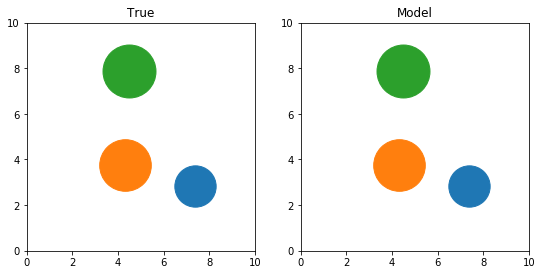

In [21]:
n_balls = 3
n_objects = n_balls + n_walls
n_relations = n_objects*(n_objects-1)
n_timesteps_test = 2
n_simulations = 1
n_features = 7
relation_dim = 1
effect_dim = 100

ode_network.odefunc.set_relations(n_objects, n_balls, 1, device)
testset =  InteractionDataset(n_timesteps_test, n_simulations, n_balls, n_relations, relation_dim)
testloader = DataLoader(testset)
with torch.no_grad():   
    for i, (initial_state, all_states, times) in enumerate(testloader):
        initial_state = initial_state.to(device)
        all_states = all_states.cpu()
        times = times.to(device)[0]

        predicted = ode_network(times, initial_state).cpu()
        plt.ion()
        for t in range(0, n_timesteps_test):
            clear_output(True)
            fig, axs = plt.subplots(1, 2, figsize = (9, 9))
            for b in range(0,n_balls):
                axs[0].set_title('True')
                axs[0].set_ylim(0,10)
                axs[0].set_xlim(0,10)
                axs[0].set_aspect('equal', 'box')
                axs[0].scatter(x=all_states[0][t][b][3],y=all_states[0][t][b][4],s=testset.radiuses[0][b][0]**2*2000)
                axs[1].set_title('Model')
                axs[1].set_ylim(0,10)
                axs[1].set_xlim(0,10)
                axs[1].set_aspect('equal', 'box')
                axs[1].scatter(x=predicted[t][0][b][3],y=predicted[t][0][b][4],s=testset.radiuses[0][b][0]**2*2000)
            plt.show()
        plt.ioff()

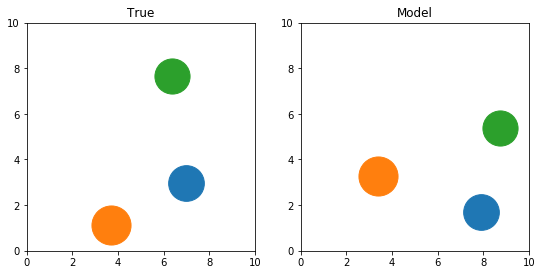

In [23]:
n_balls = 3
n_objects = n_balls + n_walls
n_relations = n_objects*(n_objects-1)
n_timesteps_test = 100
n_simulations = 1
n_features = 7
relation_dim = 1
effect_dim = 100

ode_network.odefunc.set_relations(n_objects, n_balls, 1, device)
testset = InteractionDataset(n_timesteps_test, n_simulations, n_balls, n_relations, relation_dim)
initial_states, all_states, times = testset[0]
initial_states = initial_states.squeeze(0).to(device)
all_states = all_states.squeeze(0).cpu()
times = times.squeeze(0).to(device)

with torch.no_grad():
    current_state = initial_states
    for i in range(0,int(n_timesteps_test/8)):
        times = (torch.FloatTensor([0,1,2,3,4,5,6,7])).to(device)
        predicted = ode_network(times, current_state.unsqueeze(0)).cpu()
        
        for t in range(0,7):
            clear_output(True)
            fig, axs = plt.subplots(1, 2, figsize = (9, 9))
            for b in range(0,n_balls):
                axs[0].set_title('True')
                axs[0].set_ylim(0,10)
                axs[0].set_xlim(0,10)
                axs[0].set_aspect('equal', 'box')
                axs[0].scatter(x=all_states[i*8+t][b][3],y=all_states[i*8+t][b][4],s=testset.radiuses[0][b][0]**2*2000)
                axs[1].set_title('Model')
                axs[1].set_ylim(0,10)
                axs[1].set_xlim(0,10)
                axs[1].set_aspect('equal', 'box')
                axs[1].scatter(x=predicted[t][0][b][3],y=predicted[t][0][b][4],s=testset.radiuses[0][b][0]**2*2000)
            plt.show()
        
        predicted = predicted[7].squeeze(0)
        constants = current_state[:,0:3].cpu()
        walls = current_state[-4:,:].cpu()
        current_state_balls = torch.cat([constants[0:n_balls,:], predicted[0:n_balls,-4:]], 1)
        current_state = torch.cat([current_state_balls, walls], 0).to(device)